# LISA Data Challenge: Spritz Verification Binaries
This notebook goes through the process of glitch identification, glitch removal, and then parameter estimation on the Spritz Verification Binary dataset. 

<font color="red">**WARNING:** </font>

This notebook contains cells that can take days to run, or that use 20 GB of memory to store arrays. By default, these cells are commented out and the results are hard-coded in, or loaded from files. Feel free to uncomment them and test them out if you want.

## TODO
- Visualization
- Compare results
- Clean up imports

## Setup

### Imports and Matplotlib Settings
Import needed modules for analysis and set up matplotlib to display how I want it to.

`KyeLISAModule` is a module I wrote to simplify working with LISA Data Challenge (LDC) data. Feel free to read through the code. 

In [1]:
# from IPython.display import display
import KyeLISAModule.analysis as kla
import KyeLISAModule.plot as klp
import KyeLISAModule.gridsearch as klg
import numpy as np
from numpy.fft import fft, ifft
import h5py
import matplotlib.pyplot as plt
from scipy.signal import welch, find_peaks
from scipy.interpolate import splrep, splev
from scipy.optimize import fsolve
from statsmodels.tsa.stattools import acovf
from ldc.common.series import TimeSeries, FrequencySeries
import FinalFunctions as sf
from ldc.common.tools import window
from multiprocessing import cpu_count, Pool
import pickle
from tqdm.notebook import tqdm
import ptemcee
import emcee
from corner import corner
from glob import glob

plt.rcParams["figure.figsize"] = (13, 10)

### Load LDC Datafile
This file contains all source parameters as well as the data for the analysis. It also contains some other information related to the simulation that we don't need. 

In [2]:
file = h5py.File("Data/VGB_Spritz.h5")

### Constants
Set up some constants for use later in the analysis.

In [3]:
# Get some constants for future analysis
dt = file["obs/tdi"].attrs["dt"]
N_PER_SEG = int(1e6 / dt)
T_OBS = (file["obs/tdi"]["t"].size) * dt
BASE_VARS = ("X", "Y", "Z")
GLITCH_VARS = ("X", "Y", "Z", "T")
VARS = ("X", "Y", "Z", "A", "E", "T")

### Data
Set up the data from the file into a more convenient format.

In [4]:
# Get the parameter names
param_names = file["sky/cat"].dtype.names

# Get the parameter values in a dictionary with their names as keys
params = {name: file["sky/cat"][name].squeeze() for name in param_names}

# Get the parameter units in a dictionary with their names as keys
units = {name: file["sky/cat"].attrs.get(name) for name in param_names}

In [5]:
# Get a cleaner version of the observed TDI data
obs_tdi = {}
for var in ("t", *BASE_VARS):
    obs_tdi[var] = np.asarray(file["obs/tdi"][var])[:].squeeze()

# Add the A, E, T TDI variables
obs_tdi["A"] = (obs_tdi["Z"] - obs_tdi["X"]) / np.sqrt(2.0)
obs_tdi["E"] = (obs_tdi["X"] - 2.0 * obs_tdi["Y"] + obs_tdi["Z"]) / np.sqrt(6.0)
obs_tdi["T"] = (obs_tdi["X"] + obs_tdi["Y"] + obs_tdi["Z"]) / np.sqrt(3.0)

In [6]:
# Close analysis file
file.close()
del file

## Glitch Detection

To detect glitches, we need to obtain the autocovariance (ACOV) of the noise. We start with a very rough method, chopping out data that falls too far from the mean in the regular dataset. This chopping reduces the influence of the glitches, allowing us to get an approximate estimate of the data's ACOV. If instead we had an accurate theoretical model for what the noise Power Spectral Density (PSD) should be, we could use the inverse Fourier Transform (IFT) of that model rather than this approximated version of the ACOV. 

The first element of the ACOV is an approximation of the variance of the data without glitches. Using that, and the assumption that the background noise is approximately gaussian with 0 mean, we can construct a Probability Distribution Function (PDF) for the data's amplitude without glitches. Relative to the noise, verification binary signals have a tiny amplitude, so we can ignore them when creating this PDF approximation. Thus, the PDF ends up being

$$p(A) = \frac{1}{\sqrt{2 \pi \text{ACOV}(0)}} \exp \left( -\frac{1}{2} \frac{A^2}{\text{ACOV}(0)} \right),$$

for any given (positive or negative) amplitude A.

Another statistic, which I have labelled the "quadratic statistic", given by 

$$Q = a\text{Amplitude}^2 + b\frac{d}{dt}(\text{Amplitude})^2,$$

for any given choice of $a$ and $b$, also has a PDF you can derive from the ACOV. With the assumption that the noise is gaussian, $\frac{\text{Amplitude}^2}{\text{ACOV}(0)}$ is distributed as a $\chi^2$ with one degree of freedom, which means $\text{Amplitude}^2$ has a gamma distribution, given by

$$\text{Amplitude}^2 \sim \Gamma \left(\frac{1}{2}, ~~ 2 ~\text{ACOV(0)}\right).$$

On the other hand, the $b\frac{d}{dt}(\text{Amplitude})^2$ term is approximated as $X_{i+1} - X_{i-1}$ for the discrete data we have. Since we are assuming the noise is gaussian, this becomes a gaussian random variable with a variance equal to the sum of their two variances minus two times their covariance. Thus, $\frac{b\frac{d}{dt}(\text{Amplitude})^2}{2(\text{ACOV}(0) - \text{ACOV}(2))}$ is distributed as a $\chi^2$ with one degree of freedom, which means that 

$$b\frac{d}{dt}(\text{Amplitude})^2 \sim \Gamma \left(\frac{1}{2}, ~~ 4 ~ \left(\text{ACOV(0)} - \text{ACOV(2)} \right)\right).$$

The amplitude and the slope should be independent random variables, meaning their joint PDF is given by their product. So, to find the PDF of the sum of the two random variables, you integrate their joint PDF over all values that would produce any given input to the PDF. Overall, the PDF is given by

$$p(Q) = \int_0^Q \left( \Gamma \left(\frac{1}{2}, ~~ 2 ~ \text{ACOV(0)}\right)(x) ~~~ \Gamma \left(\frac{1}{2}, ~~ 4 ~ \left(\text{ACOV(0)} - \text{ACOV(2)} \right)\right)(Q - x) \right)dx.$$

These PDFs can be derived for whitened data as well, allowing us to detect smaller glitches that pop out of the data when whitened. We just need to obtain an approximation of the whitened noise ACOVs (wACOVs), which we can accomplish by windowing out any really loud glitches, whitening, windowing any new very loud glitches, then approximating its ACOV. The whitened equivalents of amplitude $A_w$ and quadratic statistic $Q_w$ have PDFs given by

$$p(A_w) = \frac{1}{\sqrt{2 \pi \text{wACOV(0)}}} \exp \left( -\frac{1}{2} \frac{A_w^2}{\text{wACOV(0)}} \right)$$

and 

$$p(Q_w) = \int_0^{Q_w} \left( \Gamma \left(\frac{1}{2}, ~~ 2 ~ \text{wACOV(0)}\right)(x) ~~~ \Gamma \left(\frac{1}{2}, ~~ 4 ~ \left(\text{wACOV(0)} - \text{wACOV(2)} \right)\right)(Q_w - x) \right)dx.$$

Those PDFs allow us to calculate the probabilities of obtaining noise in any given range of values, denoted by $P(\text{Event})$. 

Let's say we would like to detect glitches by looking for data with amplitudes more extreme than $a$ or $a_w$ and quad stats more extreme than $q$ or $q_w$. Let's also say that we would like to label at most the fraction $\gamma$ of valid data as glitches when looking at a single data stream. 

The probability of getting $A$ more extreme than $a$ or $A_w$ more extreme than $a_w$ assuming valid, non-glitching data is given by 

$$P(|A| > a \text{ or } |A_w| > a_w) = P(|A| > a) + P(|A_w| > a_w) - P(|A| > a \text{ and } |A_w| > a_w).$$

Since both methods are trying to find glitches, we expect them to be correlated, or at worst independent. They should not be anticorrelated. Thus, we can say that

$$P(\text{A trigger}) = P(|A| > a \text{ or } |A_w| > a_w) \leq P(|A| > a) + P(|A_w| > a_w) - P(|A| > a) P(|A_w| > a_w).$$

Similarly, 

$$P(\text{Q trigger}) = P(Q > q \text{ or } Q_w > q_w) \leq P(Q > q) + P(Q_w > q_w) - P(Q > q) P(Q_w > q_w).$$

We label something as a glitch if and only if both ($A$ or $A_w$) and ($Q$ or $Q_w$) trigger, since I discovered empirically that either one by itself seems to find a lot of false alarms, but together the false alarm rate is greatly decreased without affecting the true detection rate. Once again, we expect A triggers and Q triggers to be positively correlated, since they're both searching for glitches, meaning that at worst,

$$P(\text{Glitch Flag}) = P(\text{Q trigger and A trigger}) \leq \min (P(\text{Q trigger}), P(\text{A trigger})).$$

Furthermore, we know that

$$\min (P(\text{Q trigger}), P(\text{A trigger})) \leq \min (P(|A| > a) + P(|A_w| > a_w) - P(|A| > a) P(|A_w| > a_w), ~~~ P(Q > q) + P(Q_w > q_w) - P(Q > q) P(Q_w > q_w))$$

from our previous calculations, so as a whole, we can say that

$$P(\text{Glitch Flag}) \leq \min (P(|A| > a) + P(|A_w| > a_w) - P(|A| > a) P(|A_w| > a_w), ~~~ P(Q > q) + P(Q_w > q_w) - P(Q > q) P(Q_w > q_w)).$$

Since we want $P(\text{Glitch Flag}) \leq \gamma$, we can just ensure that the expression above is equal to $\gamma$. Let's set both the expressions in the minimum above to $\gamma$. You could set one of the expressions to something far above $\gamma$, but going too far above would essentially just make that statistic trigger on all data, and it would mean that the glitch detection would rely entirely on the other statistic. Thus, I chose to have them both equal to $\gamma$, although it is possible that small variations to either value could improve detection, and that could be interesting to look into for future research. This gives us

$$P(|A| > a) + P(|A_w| > a_w) - P(|A| > a) P(|A_w| > a_w) = P(Q > q) + P(Q_w > q_w) - P(Q > q) P(Q_w > q_w) = \gamma.$$

Let's arbitrarily choose $P(Q > q) = P(Q_w > q_w)$ and $P(|A| > a) = P(|A_w| > a_w)$. Future research could investigate the effects of changing those probabilities, but without any prior information as to whether whitened or regular data is better for detecting glitches, an equal weighting is reasonable. Let

$$x = P(|A| > a) = P(|A_w| > a_w) = P(Q > q) = P(Q_w > q_w).$$

Then we have 

$$2x - x^2 = \gamma$$
$$x^2 - 2x + \gamma = 0$$
$$x = 1 \pm \sqrt{1 - \gamma}.$$

Since it's a probability and hence in the range $[0, 1]$, that means

$$P(|A| > a) = P(|A_w| > a_w) = P(Q > q) = P(Q_w > q_w) = 1 - \sqrt{1 - \gamma}.$$

Finally, to minimize the chances of accidentally labelling a transient gravitational wave (GW) source as noise, we label data as noise if it triggers ($A$ or $A_w$) and ($Q$ or $Q_w$) in the TDI T channel, which is less sensitive to GWs, or if it triggers in exactly 2/3 of TDI X, Y, or Z channels, since GWs should show up in all 3 most of the time, and glitches affecting a single laser link should only show up in two. From the above calculations, the triggers in T and X, Y, Z should both detect less than the fraction $\gamma$ of glitch-free noise, and we would expect them to be correlated, or at worst independent, meaning

$$P(\text{XYZ trigger or T trigger}) = P(\text{XYZ trigger}) + P(\text{T trigger}) - P(\text{XYZ trigger and T trigger}) \leq P(\text{XYZ trigger}) + P(\text{T trigger}) - P(\text{XYZ trigger})P(\text{T trigger}) \leq 2\gamma - \gamma ^2.$$

This means that to remove in total less than or equal to a fraction $\eta$ of glitch-free noise, $\gamma = 1 -\sqrt{1 - \eta}$ and $P(|A| > a) = P(|A_w| > a_w) = P(Q > q) = P(Q_w > q_w) = 1 - \sqrt{1 - \gamma}$, so we must choose $a$, $a_w$, $q$, and $q_w$ such that 

$$P(|A| > a) = P(|A_w| > a_w) = P(Q > q) = P(Q_w > q_w) = 1 - \sqrt[4]{1 - \eta}$$

Do note that this method ensures less than $\eta$ noise gets identified as glitches, however, since we add padding and window the data in and out with a Tukey rolloff, we are likely to lose more than $\eta$ data.

I implement this whole process below.

### Collect Needed Information

In [7]:
# Decide on the fraction of valid data we're willing to accidentally label as a glitch
FRAC_LOST = 0.01

# Get the false alarm probability for each method based off of that, using the procedure above
false_alarm_prob = 1.0 - (1.0 - FRAC_LOST) ** 0.25

### Get ACOV Approximation

In [8]:
# Get a preliminary version of the data with really obvious glitches removed
prelim_deglitch = {"t": obs_tdi["t"]}
prelim_window = {"t": obs_tdi["t"]}
for var in VARS:
    prelim_deglitch[var], prelim_window[var] = kla.window(obs_tdi[var], 7e-20, return_window=True)

In [9]:
# Get the autocovariance, ignoring locations where glitches were windowed out
autocov = {var: acovf(prelim_deglitch[var][prelim_window[var] == 1.0]) for var in VARS}

### Unwhitened

#### Unwhitened Cutoffs

In [10]:
# Find where the probability of getting a more extreme amplitude in glitch-free noise is equal to the false alarm probability
amplitude_cut = {var: float(fsolve(lambda x: (1.0 - kla.abs_amp_cdf(x, autocov[var])) - false_alarm_prob, 1e-20)) for var in GLITCH_VARS}

print("The amplitude cutoffs for each variable are:")
for key, value in amplitude_cut.items():
    print(f"{key}: {value:.5}")

The amplitude cutoffs for each variable are:
X: 3.6389e-20
Y: 3.6381e-20
Z: 3.6489e-20
T: 4.2767e-20


<font color="red">**WARNING:**</font>

This cell can take several minutes to compute if uncommented. It numerically solves 4 functions that use a numerical double integral.

It took about 11 minutes on my machine.

In [11]:
#######################################################################################################################################
##  WARNING: This cell can take several minutes to compute. It numerically solves 4 functions that use a numerical double integral.  ##
##  It took about 11 minutes on my machine.                                                                                          ##
#######################################################################################################################################

# # Find where the probability of getting a more extreme quad stat in glitch-free noise is equal to the false alarm probability
# quad_cut = {var: float(fsolve(lambda x: (1.0 - kla.quad_cdf(x, autocov[var])) - false_alarm_prob, 3e-39)) for var in GLITCH_VARS}

# I hard-coded the results of the above line of code so that I don't have to wait 11 minutes every time I want to run the notebook
quad_cut = {"X": 2.479e-39, "Y": 2.4785e-39, "Z": 2.4938e-39, "T": 3.954e-39}

print("The quadratic statistic cutoffs for each variable are:")
for key, value in quad_cut.items():
    print(f"{key}: {value:.5}")

The quadratic statistic cutoffs for each variable are:
X: 2.479e-39
Y: 2.4785e-39
Z: 2.4938e-39
T: 3.954e-39


#### Use Unwhitened Cutoffs to Deglitch and Whiten Data

In [12]:
# Get a boolean mask of the locations of data exceeding the cutoff in unwhitened amplitude
amp_glitch_mask = kla.multivar_find_glitches(obs_tdi, amplitude_cut)

In [13]:
# Get a boolean mask of the locations of data exceeding the cutoff in unwhitened quadratic statistic
quad_glitch_mask = kla.multivar_find_glitches({var: (kla.get_quad(obs_tdi[var]) if var != "t" else obs_tdi[var]) for var in ("t", *GLITCH_VARS)}, quad_cut)

In [14]:
# Get a version of the data with glitches detected using only basic amplitude and quad methods windowed out
prewhite_amp_quad_deglitch = {"t": obs_tdi["t"]}
for var in VARS:
    prewhite_amp_quad_deglitch[var], prewhite_amp_quad_window = kla.window(obs_tdi[var], glitch_mask=(amp_glitch_mask & quad_glitch_mask) | (np.isnan(obs_tdi[var])), return_window=True)

In [15]:
# Get a whitened version of the observed data
white_prelim = kla.whiten(prewhite_amp_quad_deglitch, 1e6, 1e5)

In [16]:
# Get a boolean mask of where the data is still valid after whitening
valid_indices = np.isin(prelim_deglitch["t"], white_prelim["t"])

### Whitened Autocovariance

In [17]:
# Chop out the most obvious whitened glitches
white_prelim_deglitch = {"t": white_prelim["t"]}
white_prelim_window = {"t": white_prelim["t"]}
for var in VARS:
    white_prelim_deglitch[var], white_prelim_window[var] = kla.window(white_prelim[var], 2.5, return_window=True)

In [18]:
# Get unwindowed regions
white_unwindowed = {var: (white_prelim_window[var] == 1.0) & (prewhite_amp_quad_window[valid_indices] == 1.0) & (prelim_window[var][valid_indices] == 1.0) for var in VARS}
# Get the autocovariance of the whitened data, ignoring locations where glitches were windowed out
white_autocov = {var: acovf(white_prelim_deglitch[var][white_unwindowed[var]]) for var in VARS}

### Whitened

#### Determine Cutoffs

In [19]:
# Find where the probability of finding a more extreme whitened amplitude in glitch-free noise is equal to the false alarm probability
white_amplitude_cut = {var: float(fsolve(lambda x: (1.0 - kla.abs_amp_cdf(x, white_autocov[var])) - false_alarm_prob, 1.3)) for var in GLITCH_VARS}

print("The whitened amplitude cutoffs for each variable are:")
for key, value in white_amplitude_cut.items():
    print(f"{key}: {value:.5}")

The whitened amplitude cutoffs for each variable are:
X: 1.307
Y: 1.3061
Z: 1.3061
T: 1.2993


<font color="red">**WARNING:**</font>

This cell can take several minutes to compute if uncommented. It numerically solves 4 functions that use a numerical double integral.

It took about 10 minutes on my machine.

In [20]:
#######################################################################################################################################
##  WARNING: This cell can take several minutes to compute. It numerically solves 4 functions that use a numerical double integral.  ##
##  It took about 10 minutes on my machine.                                                                                          ##
#######################################################################################################################################

# # Find where the probability of getting a more extreme whitened quad stat in glitch-free noise is equal to the false alarm probability
# white_quad_cut = {var: float(fsolve(lambda x: (1.0 - kla.quad_cdf(x, white_autocov[var])) - false_alarm_prob, 3.68)) for var in GLITCH_VARS}

# I hard-coded the results of the above line of code so that I don't have to wait 10 minutes every time I want to run the notebook
white_quad_cut = {"X": 3.6902, "Y": 3.6894, "Z": 3.6845, "T": 3.6486}

print("The whitened quadratic statistic cutoffs for each variable are:")
for key, value in white_quad_cut.items():
    print(f"{key}: {value:.5}")

The whitened quadratic statistic cutoffs for each variable are:
X: 3.6902
Y: 3.6894
Z: 3.6845
T: 3.6486


#### Get Glitch Mask

In [21]:
# Get a boolean mask of the locations of data exceeding the cutoff in whitened amplitude
white_amp_glitch_mask = kla.multivar_find_glitches(white_prelim, white_amplitude_cut)

In [22]:
# Get a boolean mask of the locations of data exceeding the cutoff in whitened quad stat
white_quad_glitch_mask = kla.multivar_find_glitches({var: (kla.get_quad(white_prelim[var]) if var != "t" else white_prelim[var]) for var in ("t", *GLITCH_VARS)}, white_quad_cut)

#### Visualization

Here are some plots to help visualize the above process

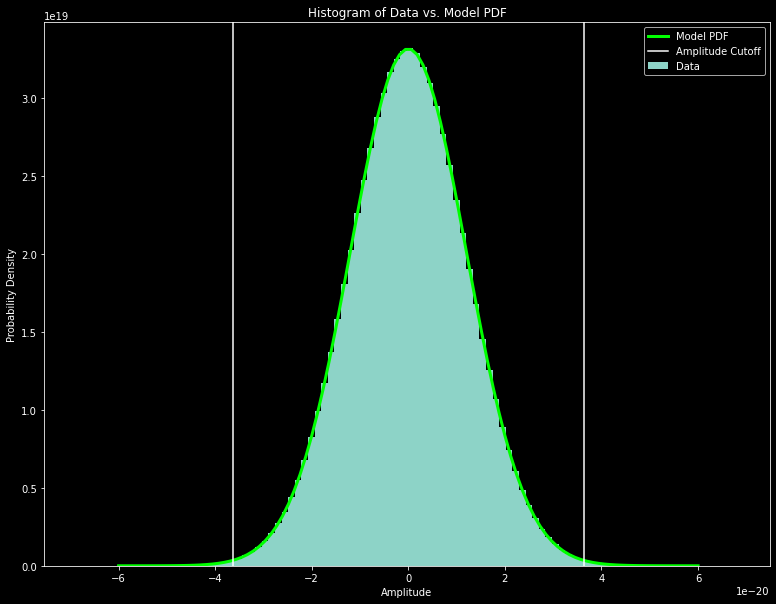

In [23]:
# Plot the amplitude histogram, cutoff and derived amplitude PDF for TDI X
plt.hist(prelim_deglitch["X"][prelim_window["X"] == 1.0], bins=100, density=True, label="Data")
x = np.linspace(-6e-20, 6e-20, 100)
plt.plot(x, kla.amp_pdf(x, autocov["X"]), color="lime", lw=3, label="Model PDF")
plt.axvline(amplitude_cut["X"], label="Amplitude Cutoff")
plt.axvline(-amplitude_cut["X"])
plt.legend()
plt.title("Histogram of Data vs. Model PDF")
plt.xlabel("Amplitude")
plt.ylabel("Probability Density")
plt.show()

## Glitch Windowing

We can now combine the boolean masks we got from the four different glitch detection methods into one mask, then window out masked data. This windowing sets all points flagged as glitches to zero, as well as 50 neighbouring points. Then, a few thousand points before and after are multiplied by half of a cosine with a period of about $10^5$ s in order to smooth out the edges of the glitch, minimizing the effects of spectral leakage. 

We also window out around gaps in the data, using essentially the exact same windowing method, just with an easier detection method.

In [24]:
# Get the glitch mask using the glitch detection from before
glitch_mask = (amp_glitch_mask[valid_indices] | white_amp_glitch_mask) & (quad_glitch_mask[valid_indices] | white_quad_glitch_mask)

# Get a boolean mask of gaps in the data
gap_mask = np.isnan(obs_tdi["T"][valid_indices])

# Combine them into one big mask of all artefacts
artefact_mask = glitch_mask | gap_mask

In [25]:
# Get a final windowed version of the data
windowed_obs_tdi = {"t": obs_tdi["t"][valid_indices]}
for var in VARS:
    windowed_obs_tdi[var], final_window_function = kla.window(obs_tdi[var][valid_indices], glitch_mask=artefact_mask, padding=50, return_window=True)

## Clean Up Glitch Detection and Windowing

These are using up a bunch of memory, and because they're global, they never get deleted unless we do this

In [26]:
del prelim_deglitch
del prelim_window
del autocov
del amplitude_cut
del quad_cut
del prewhite_amp_quad_window
del amp_glitch_mask
del quad_glitch_mask
del white_amp_glitch_mask
del white_quad_glitch_mask
del glitch_mask
del gap_mask
del artefact_mask
del obs_tdi
del white_prelim
del white_prelim_deglitch
del white_prelim_window
del white_autocov
del white_amplitude_cut
del white_quad_cut
del prewhite_amp_quad_deglitch
del white_unwindowed

## Parameter Estimation

Now that we have a dataset with glitches removed, we can use it to try to detect sources and estimate the parameters of those sources. 

To estimate parameters, we use Bayes' Theorem, 

$$p(A|B) = \frac{p(B|A)p(A)}{p(B)}.$$

This applies to parameter estimation in the following setup:

$$p(\text{Parameters}|\text{Data}) = \frac{p(\text{Data}|\text{Parameters})p(\text{Parameters})}{p(\text{Data})}.$$

The common terminology here is 

$$\text{Posterior} = \frac{\text{(Likelihood)(Prior)}}{\text{Evidence}}.$$

- The posterior is the probability distribution of parameters given the data that we have, which is what we want to know. 

- We can calculate the likelihood pretty easily with the assumption of stationary gaussian noise. This assumption is technically incorrect since the noise is most likely nonstationary, and even if it were, windowing out glitches as we did above affects the noise, making it nonstationary. The hope is that the noise is stationary *enough* that the assumption is reasonably accurate for parameter estimation, but it could be useful in the future to look into methods of mitigating the nonstationarity of the noise, either by performing analysis in a wavelet basis, by performing analysis over small regions of approximately stationary noise, or some other method. 

- The prior allows us to add our previous knowledge as to the distribution of sources into the parameter estimation. 

- We can mostly ignore the evidence for the purposes of this project, since it's just a scalar to normalize the probability distribution, and we only care about relative probabilities.

We will end up using a Monte Carlo Markov Chain (MCMC) algorithm to approximate the posterior and estimate source parameters, but in order to use this algorithm, we want to know the general region of the parameter space where the true parameters are most likely to be found. We also need to know what is a source and what isn't. 

We can't perform a scan across all of parameter space looking for maxima because with 8 parameters, and a peak width of about $10^{-9}$ Hz over a 0.01 Hz range, the number of function evaluations necessary is prohibitive. We can however analytically maximize the likelihood function (again, assuming stationary noise) across four parameters for any given other four parameters. Furthermore, the frequency derivatives of the sources are small enough that they have very little impact on the likelihood function. This means we only need to search over 3 dimensions instead of 8 to find strong peaks in likelihood.

Generally peaks in likelihood correspond to peaks in posterior unless your prior is incredibly lumpy, so we can use this maximized likelihood, called the F-Statistic, to detect sources and determine their approximate parameters so that we can then use MCMC to more accurately obtain parameter estimation. 

Below I implement this whole process of parameter estimation. The Log-Likelihood function includes the effects of windowing in its GW model, although it doesn't include it in the noise. Both functions also use all three of the A and E Time-Delay Interferometry (TDI) channels. The F-Statistic also includes the T channel. These three channels have independent noise assuming the noise in each LISA laser link is identical, which is the case for this dataset. The T channel is mostly insensitive to GWs, so it's not important to include in the log-likelihood.

### F-Statistic Gridsearch

I search over latitude, longitude, and frequency, keeping frequency derivative constant. Maxima in longitude and latitude are less sharp than in frequency, so we can scan over the whole sky with 10 points for latitude and 20 points for longitude. The F-Statistic tends to have smaller maxima surrounding the main maximum at $\pm \frac{1}{\text{year}}$. To ensure we catch the main maximum, we need to scan with a point separation of $\frac{1}{4} \frac{1}{\text{year}}$, or about $7$ nHz. All of the sources have frequencies in the range of $0.1$ mHz to $6.5$ mHz, meaning that dividing the grid into around one million points along the frequency axis is enough to catch sources. 

I would recommend runnning this on a cluster with as many CPUs as you can get, since it takes a very long time to run. 

#### Set Up For Gridsearch

In [27]:
# Set up the search
VALID_T_OBS = windowed_obs_tdi["X"].size * dt
sf.set_GB(T=VALID_T_OBS)

In [28]:
# Determine the bounds of the gridsearch
gridsearch_bounds = (np.array((1e-1, -np.pi / 2.0, 0.0)), np.array((6.5, np.pi / 2.0, 2.0 * np.pi)))

In [29]:
# Get the PSD of the deglitched data
windowed_obs_tdi_psd = kla.psd(windowed_obs_tdi, 1.0 / dt, N_PER_SEG)


# Get a smoothed noise PSD estimate as a series of points
MED_WIDTH = 200
median_psd = {"f": windowed_obs_tdi_psd["f"]}
for var in VARS:
    median_psd[var] = np.zeros(windowed_obs_tdi_psd[var].shape)
for index in range(median_psd["f"].size):
    for var in VARS:
        median_psd[var][index] = np.median(windowed_obs_tdi_psd[var][max(0, index - MED_WIDTH):1 + min(windowed_obs_tdi_psd["f"].size, index + MED_WIDTH)])

# Turn the series of points into a function
psd_spline_rep = {var: splrep(windowed_obs_tdi_psd["f"], median_psd[var]) for var in VARS}
def psd_spline(freq, option="X"):
    return splev(freq, psd_spline_rep[option], der=0)

# Clean up to get rid of unused memory
del median_psd
del windowed_obs_tdi_psd

In [30]:
# Get a fourier transform of the windowed time series
windowed_obs_fft = {var: TimeSeries(windowed_obs_tdi[var], t0=0, dt=dt).ts.fft(win=window) for var in VARS}

#### Run Gridsearch

<font color="red">**WARNING:**</font>

This cell can take several weeks to compute if uncommented. It evaluates a function 2e8 times.

I recommend you only run this on a computing cluster. 

In [31]:
###############################################################################################################
##  WARNING: This cell will take several weeks to run on most computers. It evaluates a function 2e8 times.  ##
##  I recommend you only run this on a computing cluster.                                                    ##
###############################################################################################################

# Perform a gridsearch across the entire range
# gridsearch = klg.full_gridsearch(func=sf.full_fstat, 
#                                  ndim=3, 
#                                  bounds=gridsearch_bounds, 
#                                  gridshape=(1_000_000, 10, 20), 
#                                  end_spacing=(1.0,) * 3, 
#                                  processes=cpu_count(), 
#                                  func_return_shape=9, 
#                                  func_args=(windowed_obs_fft, 
#                                             VALID_T_OBS, 
#                                             psd_spline, 
#                                             TimeSeries(final_window_function, 
#                                                        t0=0, 
#                                                        dt=dt).ts.fft(win=window)))

#### Find Gridsearch Peaks

<font color="red">**WARNING:**</font>

The following four cells require loading an array that takes around 20 GB of memory to store. If you don't have that much memory available, I recommend you skip them and just head right to the results.

In [32]:
# # Load results of gridsearch
# with open("FinalGridsearches/complete_obs_windowed_gridsearch.pickle", "rb") as picklefile:
#     gridsearch = pickle.load(picklefile)

In [33]:
# # Get a version of the gridsearch maximized along latitude and longitude
# freqs = gridsearch[0][1][:, 0, 0, 0]
# freq_fstat_max = gridsearch[0][0][..., 0].max(axis=(-1, -2))

# # Delete the giant 20 sf.GB array to free memory
# del gridsearch

In [34]:
# # Get a rolling multiple of a quantile to use as a cutoff in f-statistic detection
# fstat_cutoff = 15.0 * kla.rolling_quantile(freq_fstat_max, 0.3, 5000)

In [35]:
# # Find prominent peaks passing that f-statistic value
# peaks_indices = find_peaks(freq_fstat_max, fstat_cutoff, distance=300, prominence=10.0)[0]
# peak_freqs = freqs[peaks_indices]

In [36]:
# Load hard-coded frequencies of detected peaks so that you don't have to load the 20 GB
peak_freqs = (1.25281395, 1.25675636, 1.66473116, 1.68350238, 1.81373611, 1.94414264, 2.30786141, 2.61267451, 3.22470712, 3.51251541, 3.78836209, 4.82170712, 6.22035172)

#### Small Gridsearches Around Peaks

<font color="red">**WARNING:**</font>

This cell takes several minutes to run if uncommented. 

It took about 25 minutes on my machine with 8 cores. 

In [37]:
###############################################################################################################
##  WARNING: This cell will take several minutes to run if uncommented.                                      ##
##  It took around 25 minutes to run on my machine with 8 cores                                              ##
###############################################################################################################

# # Initialize a dictionary to store 
# fstat_grids = {}

# # For each detected peak, run a smaller gridsearch around the peak to accurately determine parameters to start our MCMC
# for peak_freq in tqdm(peak_freqs):

#     temp_gridsearch_bounds = (np.array((peak_freq - 4e-4, -np.pi / 2.0, 0.0)), np.array((peak_freq + 4e-4, np.pi / 2.0, 2.0 * np.pi)))
    
#     fstat_grids[peak_freq] = klg.full_gridsearch(func=sf.full_fstat, 
#                                                  ndim=3, 
#                                                  bounds=temp_gridsearch_bounds, 
#                                                  gridshape=(101, 10, 20), 
#                                                  end_spacing=(1.0,) * 3, 
#                                                  processes=cpu_count(), 
#                                                  func_return_shape=9, 
#                                                  verbose=True, 
#                                                  func_args=(windowed_obs_fft, 
#                                                             VALID_T_OBS, 
#                                                             psd_spline))

# Load the gridsearches above from datafiles
with open("SmallerSearches/smallgrids_windowed.pickle", "rb") as picklefile:
    fstat_grids = pickle.load(picklefile)

#### Get Maximized Parameters for MCMC Initialization

In [38]:
# Initialize an array to store the parameter estimations based off of F-Stat
max_params = np.zeros((len(fstat_grids), 8))

# Find the maximal F-Statistic in each grid and store the parameters at that point in the array
for grid_index, grid in enumerate(fstat_grids.values()):
    max_indices = np.argmax(grid[0][0][..., 0])
    max_params[grid_index] = grid[0][0][(*np.unravel_index(max_indices, grid[0][0].shape[:-1]), slice(1, None))]

# Clean up memory
del fstat_grids

### MCMC Parameter Estimation

I run an MCMC sampler in each peak detected with the F-Statistic gridsearch. 

<font color="red">**WARNING:**</font>

This cell takes several days to run if uncommented. 

It starts 13 MCMC runs with a log-posterior function that runs very slowly. 

In [39]:
###############################################################################################################
##  WARNING: This cell will take days or even weeks to run if uncommented.                                   ##
###############################################################################################################

# # Initialize the data and window function
# sf.dataf = windowed_obs_fft
# sf.fd_window_function = fft(final_window_function)

# # Store constants to use for initialization
# SQRT_VAR_VEC = np.array((0.05, 1e-6, 1e-16, 0.01, 0.1, 0.1, 0.05, 0.1))
# NDIM = 8
# NWALKERS = 20 * NDIM
# NSTEPS = 1500

# # Iterate through each peak detected with the F-Stat gridsearch and perform an MCMC search
# with Pool() as pool:
#     for peak in max_params:
#         # Get the maximum and minimum of the prior
#         prior_minimum = np.array((peak[0] - 2, peak[1] - 8e-4, -1e-14, -1.0, -0.1, -1.0, -0.1, -0.1))
#         prior_maximum = np.array((peak[0] + 2, peak[1] + 8e-4, 1e-14, 1.0, 2.0 * np.pi + 0.1, 1.0, 2.0*np.pi + 0.1, 2.0*np.pi + 0.1))
        
#         # Initialize the MCMC sampler
#         sampler = emcee.EnsembleSampler(nwalkers=NWALKERS, 
#                                         ndim=NDIM, 
#                                         log_prob_fn=sf.window_log_posterior, 
#                                         pool=pool, 
#                                         args=(psd_spline, prior_minimum, prior_maximum))
        
#         # Initialize the walkers
#         init_state = np.random.rand(NWALKERS, NDIM) * SQRT_VAR_VEC + peak
#         # Make sure walkers stay in the prior
#         for walker_index, walker in enumerate(init_state):
#             init_state[walker_index] = kla.wrap(walker, prior_minimum, prior_maximum)
        
#         # Run the MCMC sampler
#         sampler.run_mcmc(initial_state=init_state, nsteps=NSTEPS, progress="notebook")
        
#         # Save the MCMC chain
#         with open(f"FinalChains/{peak[1]:.3}_mHz_peak.pickle", "wb") as picklefile:
#             pickle.dump(sampler.chain, picklefile)

### Analysis of Parameter Estimation

In [40]:
# Get all the chain names
chain_filenames = glob("FinalChains/*.pickle")

# Import all the chains
chains = {}
for full_name in chain_filenames:
    name = full_name.removeprefix("FinalChains/").removesuffix(".pickle")
    with open(full_name, "rb") as picklefile:
        chains[name] = pickle.load(picklefile)

In [41]:
# Store the parameters in arrays
source_params = np.array((np.log10(params["Amplitude"]), 
                          1e3 * params["Frequency"], 
                          params["FrequencyDerivative"], 
                          np.sin(params["EclipticLatitude"]), 
                          params["EclipticLongitude"], 
                          np.cos(params["Inclination"]), 
                          params["Polarization"], 
                          params["InitialPhase"])).transpose()

Source is 1.7 standard deviations from the mean
log10(Amplitude) [None] estimated at -22.0031 ± 0.0063, versus -22.003 for the true value
Frequency [mHz] estimated at 4.8216981 ± 2.8e-06, versus 4.8217 for the true value
log10(Frequency Derivative) [log10(Hz/s)] estimated at 3.2e-16 ± 1.7e-16, versus 2.5378e-16 for the true value
sin(Ecliptic Latitude) [None] estimated at 0.9143 ± 0.0017, versus 0.91469 for the true value
Ecliptic Longitude [rad] estimated at 3.5732 ± 0.0067, versus 3.5784 for the true value
cos(Inclination) [None] estimated at 0.11 ± 0.0073, versus 0.10192 for the true value
Polarization Angle [rad] estimated at 5.0821 ± 0.0093, versus 5.0882 for the true value
Initial Phase [rad] estimated at 4.798 ± 0.096, versus 4.8306 for the true value


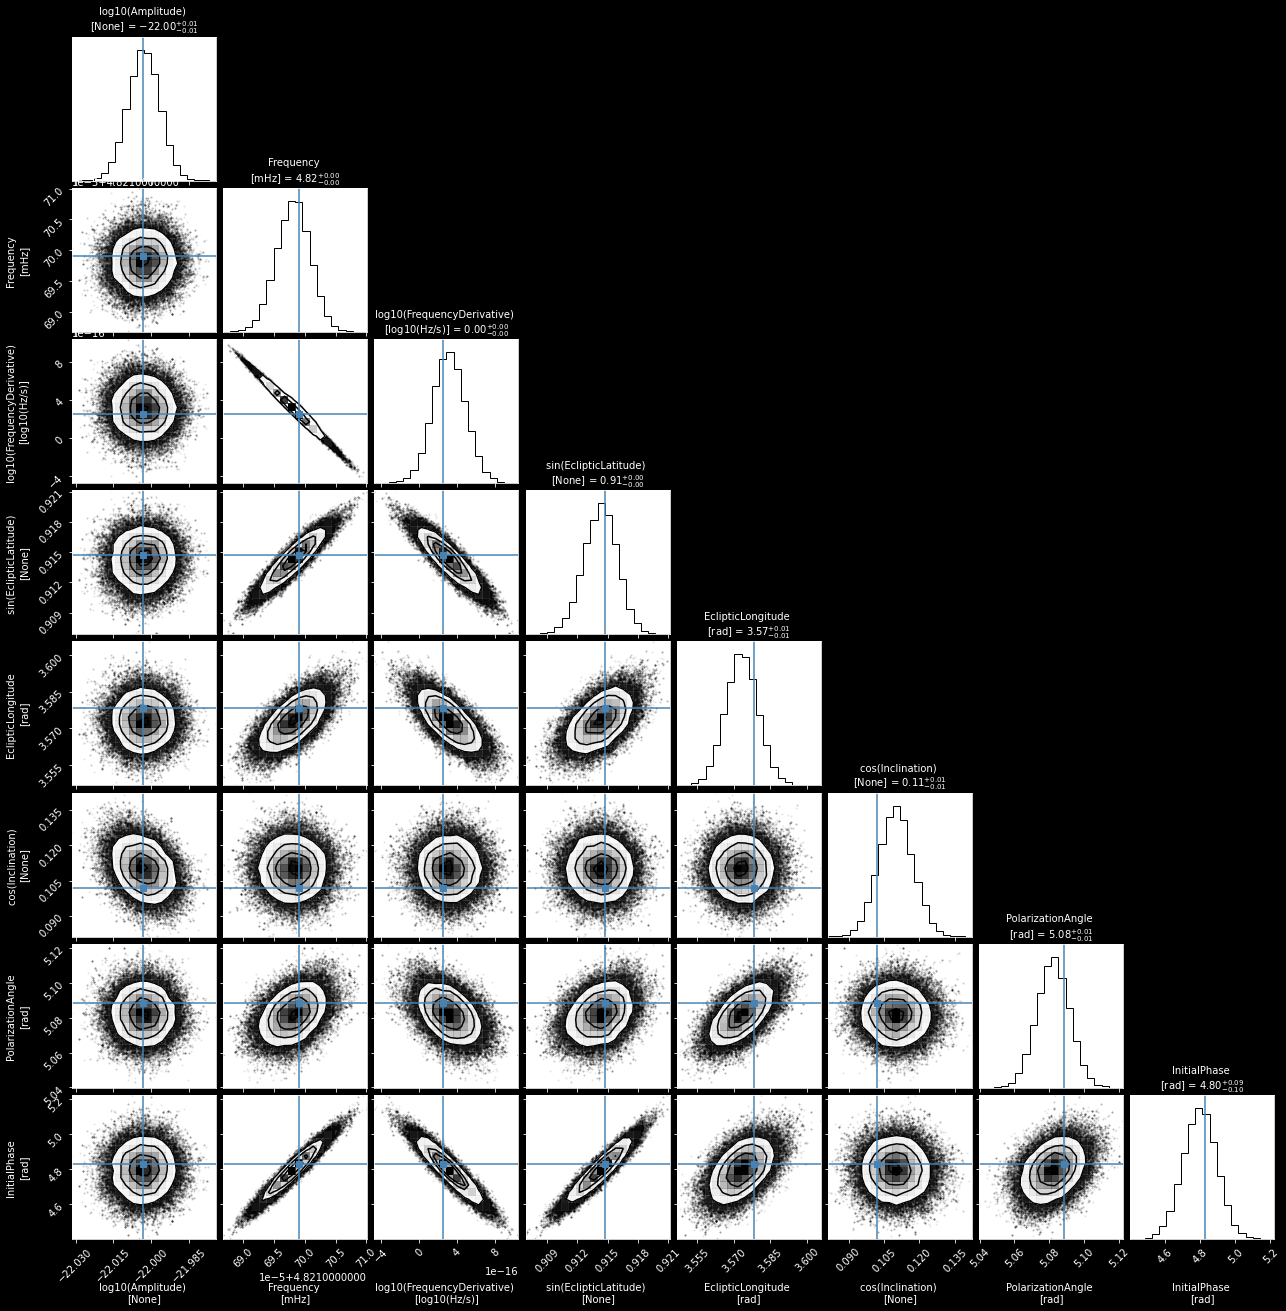

In [42]:
plt.rcParams["axes.facecolor"] = "white"

# Choose a value for the amount of burn-in
BURNIN = 500

# Store the names of the dimensions
dim_names = ("log10(Amplitude) [None]", 
             "Frequency [mHz]", 
             "log10(Frequency Derivative) [log10(Hz/s)]", 
             "sin(Ecliptic Latitude) [None]", 
             "Ecliptic Longitude [rad]", 
             "cos(Inclination) [None]", 
             "Polarization Angle [rad]", 
             "Initial Phase [rad]")

# Plot each chain and get summary statistics
means = {}
offsets = {}
stdevs = {}
cov = {}
for name, chain in chains.items():
    # Get a chain with burn-in removed
    burnt_chain = chain[:, BURNIN:].reshape(chain.shape[0] * (chain.shape[1] - BURNIN), 8)
    
    # Get summary statistics for the data
    means[name] = np.mean(burnt_chain, 0)
    stdevs[name] = np.std(burnt_chain, 0, ddof=1)
    cov[name] = np.cov(burnt_chain, rowvar=False)
    
    # Find the source with the closest parameters
    dist = source_params - means[name]
    norm_dist_sq = np.diag(np.matmul(dist, np.matmul(np.linalg.inv(cov[name]), dist.transpose())))
    closest_id = np.argmin(norm_dist_sq)
    
    # Store the offset of this distribution with its nearest source
    offsets[name] = means[name] - source_params[closest_id]
    
    # Print summary stats
    print(f"Source is {np.sqrt(norm_dist_sq[closest_id]):.2} standard deviations from the mean")
    for name, mean, stdev, source_value in zip(dim_names, means[name], stdevs[name], source_params[closest_id]):
        print(f"{name} estimated at {kla.uncert(mean, stdev)}, versus {source_value:.5} for the true value")
    
    # Make a corner plot
    corner(burnt_chain, 
           truths=source_params[closest_id], 
           labels=("log10(Amplitude) \n[None]", 
                    "Frequency \n[mHz]", 
                    "log10(FrequencyDerivative) \n[log10(Hz/s)]", 
                    "sin(EclipticLatitude) \n[None]", 
                    "EclipticLongitude \n[rad]", 
                    "cos(Inclination) \n[None]", 
                    "PolarizationAngle \n[rad]", 
                    "InitialPhase \n[rad]"), 
            show_titles=True, 
            title_kwargs={"fontsize": 10})
    plt.show()

plt.rcParams["axes.facecolor"] = "black"

In [43]:
# Get a numpy array of offsets
offsets_array = np.array(list(offsets.values()))

# Get the average bias of the entire procedure
mean_bias = np.mean(offsets_array, axis=0)
# Get the standard deviation of the bias
stdev_bias = np.std(offsets_array, axis=0, ddof=1) if offsets_array.shape[0] > 1 else np.zeros(8)

# Print the results
for title, mean, stdev in zip(dim_names, mean_bias, stdev_bias):
    print(f"{title} has a bias of {kla.uncert(mean, stdev)}")

log10(Amplitude) [None] has a bias of 0.0 ± 0.0
Frequency [mHz] has a bias of -0.0 ± 0.0
log10(Frequency Derivative) [log10(Hz/s)] has a bias of 0.0 ± 0.0
sin(Ecliptic Latitude) [None] has a bias of -0.0 ± 0.0
Ecliptic Longitude [rad] has a bias of -0.0 ± 0.0
cos(Inclination) [None] has a bias of 0.0 ± 0.0
Polarization Angle [rad] has a bias of -0.0 ± 0.0
Initial Phase [rad] has a bias of -0.0 ± 0.0


In [44]:
# Is there a bias? With only one file, there will always be a bias since we have no standard deviation
if (stdev_bias != 0.0).all() and (np.abs(mean_bias / stdev_bias) < 1.0).all():
    print("The bias is consistent with having 0 mean")
elif (stdev_bias != 0.0).all() and (np.abs(mean_bias / stdev_bias) < 3.0).all():
    print("The bias might have 0 mean")
else:
    print("There appears to be a bias with a mean significantly different than 0")

There appears to be a bias with a mean significantly different than 0
